In [1]:
using Parameters: @unpack # or using UnPack
using PyPlot
rc("axes.spines", top=false, right=false)

In [2]:
abstract type Layer end
abstract type Neuron <: Layer end
abstract type SpikeNeuron <: Neuron end

abstract type Synapse <: Layer end

In [3]:
@kwdef struct HHParameter{FT}
    Cm::FT = 1 # 膜容量(uF/cm^2)
    gNa::FT = 120; gK::FT = 36; gL::FT = 0.3 # Na+, K+, leakの最大コンダクタンス(mS/cm^2)
    ENa::FT = 50; EK::FT = -77; EL::FT = -54 # Na+, K+, leakの平衡電位(mV)
end

@kwdef mutable struct HH{FT} <: SpikeNeuron
    num_neurons::UInt16
    dt::FT = 1e-3
    param::HHParameter = HHParameter{FT}()
    v::Vector{FT} = fill(-65, num_neurons)
    m::Vector{FT} = fill(0.05, num_neurons) 
    h::Vector{FT} = fill(0.6, num_neurons)
    n::Vector{FT} = fill(0.32, num_neurons)
end

In [4]:
function update!(neuron::HH, Iext::Vector)
    @unpack num_neurons, dt, v, m, h, n = neuron
    @unpack Cm, gNa, gK, gL, ENa, EK, EL = neuron.param
    @inbounds for i = 1:num_neurons
        αm = 0.1(v[i]+40)/(1 - exp(-0.1(v[i]+40)))
        βm = 4exp(-(v[i]+65)/18)
        αh = 0.07exp(-0.05*(v[i]+65))
        βh = 1/(1 + exp(-0.1*(v[i]+35)))
        αn = 0.01(v[i]+55)/(1 - exp(-0.1(v[i]+55)))
        βn = 0.125exp(-0.0125(v[i]+65))
        
        m[i] += dt * (αm *(1 - m[i]) - βm * m[i])
        h[i] += dt * (αh *(1 - h[i]) - βh * h[i])
        n[i] += dt * (αn *(1 - n[i]) - βn * n[i])
        
        INa = gNa * m[i]^3 * h[i] * (v[i] - ENa)
        IK = gK * n[i]^4 * (v[i] - EK)
        IL = gL * (v[i] - EL)
        
        v[i] += dt / Cm * (Iext[i] - INa - IK - IL)
    end
    return v
end

(layer::Layer)(x) = update!(layer, x)

In [5]:
T = 450 # ms
dt = 0.01 # ms
nt = Int(T/dt) # number of timesteps
num_neurons = 1 # number of neurons
time = (1:nt)*dt # time array
Ie = repeat(10 * ((time .> 50) - (time .> 200)) + 35 * ((time .> 250) - (time .> 400)), 1, num_neurons)  # injection current
varr, gatearr = zeros(nt, num_neurons), zeros(nt, 3, num_neurons) # 記録用

hh_neurons = HH{Float32}(num_neurons=num_neurons, dt=dt) # modelの定義

# simulation
@time for t = 1:nt
    v = hh_neurons(Ie[t, :])
    varr[t, :] = v
    gatearr[t, :, :] .= [hh_neurons.m; hh_neurons.h; hh_neurons.n]
end

  0.476917 seconds (2.71 M allocations: 77.083 MiB, 3.29% gc time, 66.07% compilation time)


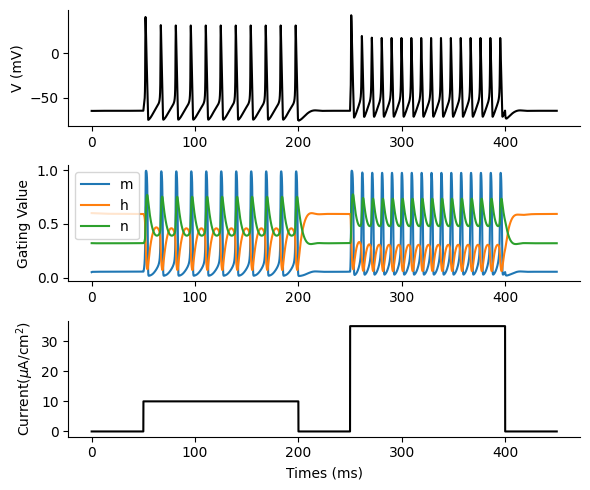

In [6]:
figure(figsize=(6, 5))
subplot(3,1,1); plot(time, varr[:, 1], color="black"); ylabel("V (mV)")
subplot(3,1,2); labellist=["m" "h" "n"] 
for i in 1:3
    plot(time, gatearr[:, i, 1], label=labellist[i])
end; 
ylabel("Gating Value"); legend()
subplot(3,1,3); plot(time, Ie[:, 1], color="black"); ylabel(L"Current($\mu$A/cm$^2$)"); xlabel("Times (ms)")
tight_layout()

In [7]:
function get_num_spikes(varr)
    spike = (varr[1:end-1, :] .< 0) .& (varr[2:end, :] .> 0)
    return sum(spike, dims=1)
end

num_spikes = get_num_spikes(varr)
println("Num. of spikes : ", num_spikes[1])

Num. of spikes : 27


In [8]:
@kwdef struct CSParameter{FT}
    Cm::FT = 1 # 膜容量(uF/cm^2)
    gNa::FT = 120; gK::FT = 20; gA::FT = 47.7; gL::FT = 0.3 # Na+, K+, KA, leakの最大コンダクタンス(mS/cm^2)
    ENa::FT = 55; EK::FT = -72; EA::FT = -75; EL::FT = -17  # Na+, K+, KA, leakの平衡電位(mV)
end

@kwdef mutable struct CS{FT} <: SpikeNeuron
    num_neurons::UInt16
    dt::FT = 1e-3
    param::CSParameter = CSParameter{FT}()
    v::Vector{FT} = fill(-65, num_neurons)
    m::Vector{FT} = fill(0.05, num_neurons) 
    h::Vector{FT} = fill(0.6, num_neurons)
    n::Vector{FT} = fill(0.32, num_neurons)
    a::Vector{FT} = fill(0.66, num_neurons)
    b::Vector{FT} = fill(0.22, num_neurons)
end

In [9]:
function update!(neuron::CS, Iext::Vector)
    @unpack num_neurons, dt, v, m, h, n, a, b = neuron
    @unpack Cm, gNa, gK, gA, gL, ENa, EK, EA, EL = neuron.param
    @inbounds for i = 1:num_neurons
        αm = 0.38(v[i]+29.7)/(1 - exp(-0.1(v[i]+29.7)))
        βm = 15.2exp(-(v[i]+54.7)/18)
        αh = 0.266exp(-0.05*(v[i]+48))
        βh = 3.8/(1 + exp(-0.1*(v[i]+18)))
        αn = 0.02(v[i]+45.7)/(1 - exp(-0.1(v[i]+45.7)))
        βn = 0.25exp(-0.0125(v[i]+55.7))
        
        a∞ = ((0.0761exp((v[i]+94.22)/31.84)) / 1+exp((v[i]+1.17)/28.93))^(1/3)
        τa = 0.3632+1.158/(1+exp((v[i]+55.96)/20.12))
        b∞ = (1+exp((v[i]+53.3)/14.54))^(-4)
        τb = 1.24+2.678/(1+exp((v[i]+50)/16.027))
        
        m[i] += dt * (αm *(1 - m[i]) - βm * m[i])
        h[i] += dt * (αh *(1 - h[i]) - βh * h[i])
        n[i] += dt * (αn *(1 - n[i]) - βn * n[i])
        a[i] += dt * (a∞ - a[i]) / τa
        b[i] += dt * (b∞ - b[i]) / τb
        
        INa = gNa * m[i]^3 * h[i] * (v[i] - ENa)
        IK = gK * n[i]^4 * (v[i] - EK)
        IA = gA * a[i]^3 * b[i] * (v[i] - EA)
        IL = gL * (v[i] - EL)
        
        v[i] += dt / Cm * (Iext[i] - INa - IK - IA - IL)
    end
    return v
end

update! (generic function with 2 methods)

In [10]:
T = 450 # ms
dt = 0.01 # ms
nt = Int(T/dt) # number of timesteps
num_neurons = 1 # number of neurons
time = (1:nt)*dt # time array
Iext_cs = repeat(25 * ((time .> 50) - (time .> 200)) + 35 * ((time .> 250) - (time .> 400)), 1, num_neurons)  # injection current
varr_cs = zeros(nt, num_neurons) # 記録用

cs_neurons = CS{Float32}(num_neurons=num_neurons, dt=dt) # modelの定義

# simulation
@time for t = 1:nt
    v = cs_neurons(Iext_cs[t, :])
    varr_cs[t, :] = v
end

  0.136361 seconds (2.14 M allocations: 39.077 MiB, 5.03% gc time, 40.63% compilation time)


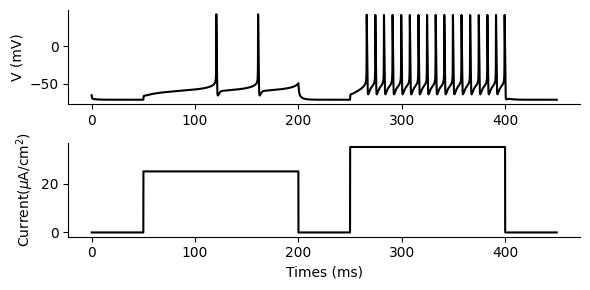

In [11]:
figure(figsize=(6, 3))
subplot(2,1,1); plot(time, varr_cs[:, 1], color="black"); ylabel("V (mV)")
subplot(2,1,2); plot(time, Iext_cs[:, 1], color="black"); ylabel(L"Current($\mu$A/cm$^2$)"); xlabel("Times (ms)")
tight_layout()

In [12]:
function fi_curve(NeuronType; num_neurons=300, T=1000, dt=0.025,
                  current_range = [1, 30])
    nt = Int(T/dt) # number of timesteps
    Iext_range = Array{Float32}(range(current_range..., length=num_neurons)) # injection current
    neurons = NeuronType{Float32}(num_neurons=num_neurons, dt=dt) # modelの定義
    varr_fi = zeros(Float32, nt, num_neurons) # 記録用

    # simulation
    for t = 1:nt
        v = neurons(Iext_range)
        varr_fi[t, :] = v
    end
    num_spikes = get_num_spikes(varr_fi)
    rate = num_spikes/T*1e3;
    threshold = Iext_range[findfirst(rate .> 1)[2]]
    return Iext_range, rate, threshold
end

fi_curve (generic function with 1 method)

In [13]:
Iext_range_hh, rate_hh, threshold_hh = fi_curve(HH, current_range = [1, 20])
Iext_range_cs, rate_cs, threshold_cs = fi_curve(CS, current_range = [20, 40]);

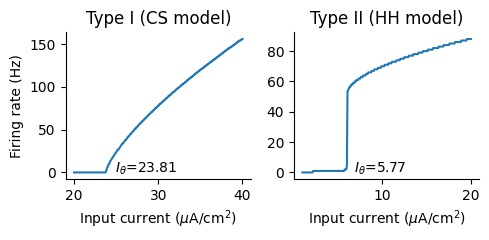

In [14]:
figure(figsize=(5, 2.5))
subplot(1,2,1)
title("Type I (CS model)")
text(threshold_cs+1, 0, L"$I_{\theta}$="*string(round(threshold_cs, digits=2)))
plot(Iext_range_cs[:], rate_cs[1, :]); xlabel(L"Input current ($\mu$A/cm$^2$)"); ylabel("Firing rate (Hz)")

subplot(1,2,2)
title("Type II (HH model)")
text(threshold_hh+1, 0, L"$I_{\theta}$="*string(round(threshold_hh, digits=2)))
plot(Iext_range_hh[:], rate_hh[1, :]); xlabel(L"Input current ($\mu$A/cm$^2$)"); 
tight_layout()

In [15]:
T = 450 # ms
dt = 0.01 # ms
nt = Int(T/dt) # number of timesteps
num_neurons = 1 # number of neurons
time = (1:nt)*dt # time array
Ie = repeat(10 * (-(time .> 50) + (time .> 200)) + 20* (-(time .> 250) + (time .> 400)), 1, num_neurons)  # injection current
varr, gatearr = zeros(nt, num_neurons), zeros(nt, 3, num_neurons) # 記録用

hh_neurons = HH{Float32}(num_neurons=num_neurons, dt=dt) # modelの定義

# simulation
@time for t = 1:nt
    v = hh_neurons(Ie[t, :])
    varr[t, :] = v
    gatearr[t, :, :] .= [hh_neurons.m; hh_neurons.h; hh_neurons.n]
end

  0.157144 seconds (2.16 M allocations: 40.442 MiB, 9.95% gc time)


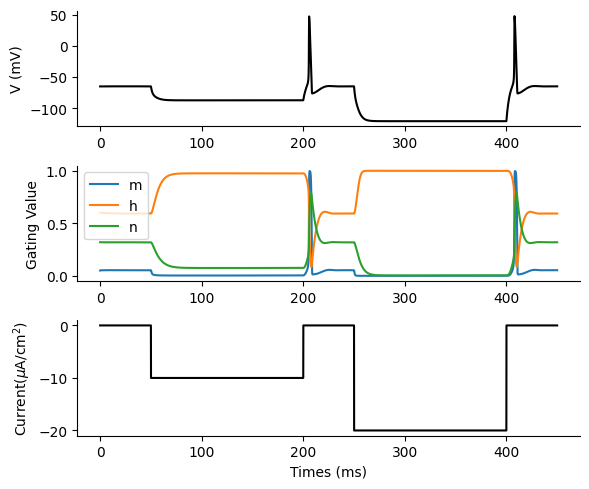

In [16]:
figure(figsize=(6, 5))
subplot(3,1,1); plot(time, varr[:, 1], color="black"); ylabel("V (mV)")
subplot(3,1,2); labellist=["m" "h" "n"] 
for i in 1:3
    plot(time, gatearr[:, i, 1], label=labellist[i])
end; 
ylabel("Gating Value"); legend()
subplot(3,1,3); plot(time, Ie[:, 1], color="black"); ylabel(L"Current($\mu$A/cm$^2$)"); xlabel("Times (ms)")
tight_layout()